## Librerías

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from IPython.display import display
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy.stats import shapiro, spearmanr, levene, kruskal, mannwhitneyu, chi2_contingency, ttest_ind
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Funcs

In [15]:
#Normalizar pais
def normalizar_pais(df, columnas_a_normalizar, df_paises_norm):
    for col in columnas_a_normalizar:
        df = pd.merge(
            df,
            df_paises_norm,
            how='left',
            left_on=col,
            right_on='PAIS A NORMALIZAR'
        )
        df.drop(columns=['PAIS A NORMALIZAR', col], inplace=True)
        df.rename(columns={'PAIS': col}, inplace=True)
    return df
#Agrupacion de paises
def agrupar_pais(df, columnas_paises, df_agrupaciones_paises):
    for col in columnas_paises:
        df = pd.merge(
            df,
            df_agrupaciones_paises,
            how='left',
            left_on=col,
            right_on='PAIS'
        )
        df.drop(columns=['PAIS'], inplace=True)
        df.rename(columns={'CLASIFICACION_MKT': f'AGRUPACION {col}'}, inplace=True)
    return df

#comprobar normalidad de las variables
def comprobar_normalidad(df, var1, var2):
    _, p1 = shapiro(df[var1])
    _, p2 = shapiro(df[var2])
    
    if p1 > 0.05 and p2 > 0.05:
        print("Ambas variables tienen distribución normal → puedes usar Pearson.")
        return True
    else:
        print("Alguna variable no es normal → mejor usar Spearman.")
        return False
    # Spearman
    spearman_corr, p_spearman = spearmanr(df[var1], df[var2])
    print(f"Spearman: ρ = {spearman_corr:.3f}, p = {p_spearman:.3f}")

def correlacion_variables(df, var1, var2):
    print (f"Comprobando correlación entre {var1} y {var2} \n")
    normalidad = comprobar_normalidad(df, var1, var2)
    
    if normalidad:
        corr, p = spearmanr(df[var1], df[var2])
        print(f"Normalidad en la distribución => Correlación de Pearson: r = {corr:.3f}, p = {p:.3f}")
        if p < 0.05:
            print("La correlación es estadísticamente significativa.")
        else:
            print("La correlación no es estadísticamente significativa.")
    else:
        corr, p = spearmanr(df[var1], df[var2])
        print(f"Sin normalidad en la distribución => Correlación de Spearman: ρ = {corr:.3f}, p = {p:.3f}")
        if p < 0.05:
            print("La correlación es estadísticamente significativa.")
        else:
            print("La correlación no es estadísticamente significativa.")

# Comprobar normalidad y varianza de los grupos
def comprobar_nomalidad_y_varianza(grupos): 
    # 1. Shapiro-Wilk test para normalidad
    for name, values in grupos:
        stat, p = shapiro(values)
        print(f'{name}: p normalidad = {p:.3f}')
        if p < 0.05:
            print(f"{name} no sigue una distribución normal.")
        else:
            print(f"{name} sigue una distribución normal.")

    # 2. Levene para varianzas iguales
    stat, p = levene(*[g for name, g in grupos])
    print(f'Levene p = {p:.3f}')
    if p < 0.05:
        print("Las varianzas son significativamente diferentes.")
    else:
        print("Las varianzas son homogéneas.")

#Calculo de la fuerza de asociacion entre dos variables sin normalidad y / o con varianzas diferentes entre dos grupos
def calcular_fuerza_asociacion_2_grupos(grupos):
    stat, p = mannwhitneyu(*[g for name, g in grupos])
    print(f'Mann-Whitney U: U = {stat:.2f}, p = {p:.3f}')
    if p < 0.05:
        print("Hay diferencias significativas entre los grupos.")
    else:
        print("No hay diferencias significativas entre los grupos.")

#Calculo de la fuerza de asociacion entre dos variables sin normalidad y / o con varianzas diferentes entre más de dos grupos
def calcular_fuerza_asociacion_mas_2_grupos(grupos):
    stat, p = kruskal(*[g for name, g in grupos])
    print(f'Kruskal-Wallis: H = {stat:.2f}, p = {p:.3f}')
    if p < 0.05:
        print("Hay diferencias significativas entre los grupos.")
    else:
        print("No hay diferencias significativas entre los grupos.")


def cramers_v(tabla):
    chi2 = chi2_contingency(tabla)[0]
    n = tabla.sum().sum()
    return np.sqrt(chi2 / n)



def calcular_independencia_categoricas(df, var1, var2):
    tabla = pd.crosstab(df[var1], df[var2])
    chi2, p, dof, expected = chi2_contingency(tabla)
    V = cramers_v(tabla)
    return var1, var2, chi2, p, V

#Ver si es significativa variable numerica vs. varaible de grupo
def prueba_comparacion_2grupos_variable(df_num_col, variable_grupo, alpha=0.05):
    # Unir variable numérica y de grupo en un mismo dataframe
    df_temp = df_num_col.to_frame(name='valor')
    df_temp['grupo'] = variable_grupo

    # Obtener los dos grupos
    grupos_unicos = df_temp['grupo'].dropna().unique()
    if len(grupos_unicos) != 2:
        return

    grupos = [
        (str(g), df_temp[df_temp['grupo'] == g]['valor'].dropna())
        for g in grupos_unicos
    ]

    normalidad = {}
    
    for name, values in grupos:
        stat, p = shapiro(values)
        normal = p >= alpha
        normalidad[name] = normal

    stat, p_var = levene(*[g for _, g in grupos])
    iguales_varianzas = p_var >= alpha

    todos_normales = all(normalidad.values())

    grupo1 = grupos[0][1]
    grupo2 = grupos[1][1]

    if todos_normales:
        t_stat, p_test = ttest_ind(grupo1, grupo2, equal_var=iguales_varianzas)
        metodo = "t-test"
        stat = t_stat
    else:
        u_stat, p_test = mannwhitneyu(grupo1, grupo2, alternative='two-sided')
        metodo = "Mann-Whitney"
        stat = u_stat
    return p, p_var, metodo, stat, p_test


# Carga

In [16]:
df_deuda = pd.read_excel('../data/estado_cartera.xlsx')
df_seguimiento = pd.read_excel('../data/Seguimiento cobros 2404.xlsx')
#df_convo_online = pd.read_excel('../data/v_com_convocatorio_v2.xlsx')
df_convo= pd.read_excel('../data/Convocatorio NG OBS 2024.xlsx', sheet_name='CONVOCATORIO OBS')
#df_convo_25 = pd.read_excel('../data/Convocatorio NG OBS 2025.xlsx', sheet_name='CONVOCATORIO OBS')
df_paises_norm = pd.read_excel('../data/paises.xlsx', sheet_name="NORMALIZACION PAISES")
df_agrupaciones_paises = pd.read_excel('../data/paises.xlsx', sheet_name="PAISES")


In [17]:
df_convo

,STATUS,SEGUIMIENTO,FECHA SEGUIMIENTO,PENDIENTE,FECHA FINALIZACION MATRICULA,TIPOLOGIA MATRICULA,TIPOLOGIA ALUMNO,ID OPORTUNIDAD,ID NACS,DIA CERO,...,OBSERVACIONES COMISION,ULT CONEXIÓN BB,SITUACION COBROS NACS,VERIFICACION SITUACION COBRO,IMPORTE PENDIENTE PAGO (CIERRE CONTABLE),PROPUESTA CIERRE CONTABLE,OBSERVACIONES CIERRE CONTABLE,INCIDENCIAS SIN RESOLVER,LINEA COMPLETA,Forma de Pago en Atenea
0,NaN,NaN,NaT,NaN,NaN,CC,CE,2021-000392047,1292060.0,NaN,...,NaN,0,NaN,NaN,1292060.0,0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaT,NaN,NaN,ALTA,CE,2021-000392434,1293191.0,NaN,...,NaN,0,NaN,NaN,1293191.0,0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaT,NaN,NaN,ALTA,CE,2021-000363664,1293265.0,NaN,...,NaN,0,NaN,NaN,1293265.0,0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaT,NaN,NaN,BAJA,CE,2021-000307185,1296703.0,NaN,...,NaN,0,NaN,NaN,1296703.0,0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaT,NaN,NaN,CC,CE,2021-000472784,1297043.0,NaN,...,NaN,0,NaN,NaN,1297043.0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4146,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,1354256.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4147,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,1354367.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4148,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,1354534.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4149,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,1354969.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# TRANSFORM

## Convocatorio 2024

In [18]:
# Mantener 'ULT CONEXIÓN BB' para estudiar alumnos con riesgo de impago durante el curso
df_convo.drop(columns=['STATUS', 'SEGUIMIENTO', 'FECHA SEGUIMIENTO', 'PENDIENTE', 'FECHA FINALIZACION MATRICULA', 'FECHA INSCRIPCIÓN', 'SEMANA COMERCIAL PRODUCCION',
       'MES COMERCIAL PRODUCCION', 'SEMANA COMERCIAL INSCRIPCION',
       'MES COMERCIAL INSCRIPCION', 'OBSERVACIONES MATRICULACION','PROGRAMA','TIPO PROGRAMA', 'CAMPUS',
       'NOMBRES APELLIDOS',  'PROVINCIA',
       'ECTS MATRICULADOS', 'ECTS RECONOCIDOS', 'ECTS RECONOCIDOS 1er AÑO',
       'ECTS RECONOCIDOS 2do AÑO', 'ECTS RECONOCIDOS 3er AÑO',
       'ECTS NUEVOS 1er AÑO', 'ECTS CONVALIDADOS', 'IMPORTE DTO FECHA MATRICULACION', 'IMP. DTO. COMERCIAL',
       'IMP. DTO APERT/CIERRE', 'DESCRIPTIVO DTO. APERT/CIERRE',
       'IMP. DTO. REF.', 'DESCRIPTIVO REF.', 'IMP. DTO. OTROS',
       'DESCRIPTIVO DTO. OTROS', 'IMPORTE DTO PAGO CONTADO',
       'DESCRIPTIVO DTO. FINANCIERO', 'DTO. ETCS NO MATRICULADOS',
       'RECON. Y CONVAL. ETCS','PI PENDIENTE', 'FECHA CARTA COMPROMISO DE PAGO PI', 'FECHA CARTA COMPROMISO DE PAGO','EQUIPO', 'JEFE EQUIPO', 'DIRECTOR VENTAS', 'FECHA MODIFICACION',
       'SEMANA COMERCIAL MODIFICACION', 'MES COMERCIAL MODIFICACION',
       'CONVOCATORIA ORIGEN', 'PROGRAMA ORIGEN', 'OBSERVACIONES CAMBIO CONV.',
       'TASA', 'FACTURACION NETA ORIGINAL', 'NUMERO DE CUOTAS ORIGINAL','FECHA REC MAIL', 'FECHA BAJA',
       'SEMANA COMERCIAL BAJA', 'MES COMERCIAL BAJA', 'FECHA GI',
       'PERIODO DESISTIMIENTO', 'MOTIVO DE BAJA', 'OBSERVACIONES BAJA',
       'CORRESPONDE DEVOLUCION', 'MES COMISIONES', 'COMISION CONTADO',
       'MES PAGO COMISION CONTADO', 'OBSERVACIONES COMISION','ULT CONEXIÓN BB', 'SITUACION COBROS NACS',
       'VERIFICACION SITUACION COBRO',
       'IMPORTE PENDIENTE PAGO (CIERRE CONTABLE)', 'PROPUESTA CIERRE CONTABLE',
       'OBSERVACIONES CIERRE CONTABLE', 'INCIDENCIAS SIN RESOLVER',
       'LINEA COMPLETA', 'Forma de Pago en Atenea'], inplace=True)

#Crear columna "TIPO PROGRAMA" segun MST o MBA.
df_convo['ID PROGRAMA'] = df_convo['ID PROGRAMA'].astype(str).str[:-2]
df_convo['TIPO PROGRAMA'] = df_convo['ID PROGRAMA'].astype(str).str[-3:].apply(lambda x: 'MBA' if x in ['990', '900', '902', '620'] else 'MST')

#Rellenar columna Forma de pago original
df_convo['FORMA DE PAGO ORIGINAL'].fillna(df_convo['FORMA DE PAGO'], inplace=True)

#Rellenar columna Medio de pago importe pendiente
df_convo['MEDIO PAGO IMPORTE PENDIENTE'].fillna('SIN IMPORTE PTE', inplace=True)


# Convertir las variables pertientes a numericas
columnas_numericas = ['PRECIO CURSO', 'FACTURACIÓN NETA', 'IMPORTE INSCRIPCIÓN', '% INSCRIPCION',
       'IMPORTE PENDIENTE PAGO']
for col in columnas_numericas:
    df_convo[col] = pd.to_numeric(df_convo[col], errors='coerce')

df_convo['NUMERO DE CUOTAS'] = df_convo['NUMERO DE CUOTAS'].astype('Int64')

df_convo = df_convo.dropna(subset=['ID NACS'])
df_convo['ID NACS'] = df_convo['ID NACS'].astype(int)

# Convertir las variables pertientes a fechas
columnas_fechas = ['FECHA PRODUCCIÓN',  'FECHA 1ra CUOTA',
       'FECHA 1ra CUOTA ORIGINAL',]
for col in columnas_fechas:
    df_convo[col] = pd.to_datetime(df_convo[col], errors='coerce')

# Convertir las variables pertientes a booleanas
df_convo['DIA CERO'] = df_convo['DIA CERO'].map(lambda x: True if x == 'SI' else False)

#Normalizar paises
df_paises_norm.drop_duplicates(subset='PAIS A NORMALIZAR', keep='first', inplace=True)
df_paises_norm.drop(columns=['FUENTE-PAIS', 'FUENTE'], inplace=True)
df_convo = normalizar_pais(df_convo, ['NACIONALIDAD', 'PAÍS DE RESIDENCIA'], df_paises_norm)

#Agrupar Paises
df_agrupaciones_paises.drop_duplicates(subset='PAIS', keep='first', inplace=True)
df_agrupaciones_paises = df_agrupaciones_paises[['PAIS', 'CLASIFICACION_MKT']]
df_convo = agrupar_pais(df_convo, ['NACIONALIDAD', 'PAÍS DE RESIDENCIA'], df_agrupaciones_paises)

# Convertir las variables pertientes a categoricas
columnas_categoricas = ['TIPOLOGIA MATRICULA', 'TIPOLOGIA ALUMNO', 'ID OPORTUNIDAD',
       'DIA CERO', 'CONVOCATORIA', 'ID PROGRAMA',
       'TIPO PROGRAMA', 'NACIONALIDAD', 'PAÍS DE RESIDENCIA', 
       'MEDIO PAGO PI', 'MEDIO PAGO IMPORTE PENDIENTE', 
       'FORMA DE PAGO', 'ASESOR', 
       'FORMA DE PAGO ORIGINAL', 'AGRUPACION NACIONALIDAD', 'AGRUPACION PAÍS DE RESIDENCIA'
         ]
for col in columnas_categoricas:
    df_convo[col] = df_convo[col].astype('category')

#CREACION DE NUEVAS COLUMNAS
#Medio de pago PI = resto de pagos
df_convo['MANTIENE MEDIO PAGO'] = df_convo['MEDIO PAGO PI'].astype(str) == df_convo['MEDIO PAGO IMPORTE PENDIENTE'].astype(str)

#Cambio en la fecha 1a cuota
df_convo['DIFERENCIA FECHA 1ra CUOTA - ORIGINAL'] = (df_convo['FECHA 1ra CUOTA'] - df_convo['FECHA 1ra CUOTA ORIGINAL']).dt.days
df_convo.fillna({'DIFERENCIA FECHA 1ra CUOTA - ORIGINAL': 0}, inplace=True)

#Diferencia entre la fecha de produccion y la fecha de 1ra cuota
df_convo['DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA'] = (df_convo['FECHA 1ra CUOTA'] - df_convo['FECHA PRODUCCIÓN']).dt.days
df_convo.fillna({'DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA': 0}, inplace=True)

#% de Descuento
df_convo ['% DTO'] = 1-(df_convo['FACTURACIÓN NETA']/df_convo['PRECIO CURSO'])

## Estado cartera

In [ ]:
#Tratar datos de estado cartera
#Crear FP1 y Cuotas
df_deuda['FP1'] = df_deuda['Forma Pago'].str[0]
df_deuda['Cuotas'] = df_deuda['Forma Pago'].str[-2:]

#Convertir los NAs
df_deuda.fillna({
    'Importe Impagado Actual': 0,
    'Importe Neto Factura': 0,
    'Importe Cartera': 0,
    'Importe Vdo': 0,
    'Importe Recobrado': 0,
    'Importe Cobrado': 0,
    'Importe No Vencido': 0,
    'Marca': '',
    'Convocatoria': '',
    'FP1': '',
    'Cuotas': 0
}, inplace=True)

#Agrupar por 'Cod. NACS' y sumar las columnas pertinentes
df_deuda = df_deuda.groupby('Cod. NACS').aggregate({
    'Marca': 'first',
    'Convocatoria': 'first',
    'FP1': 'first',
    'Cuotas': 'first', 
    'Importe Impagado Actual': 'sum',
    'Importe Neto Factura': 'sum',
    'Importe Cartera': 'sum',
    'Importe Vdo': 'sum',
    'Importe Recobrado': 'sum',
    'Importe Cobrado': 'sum',
    'Importe No Vencido': 'sum'
    })

#Nueva columna para los morosos
df_deuda['Moroso'] = df_deuda['Importe Impagado Actual'] > 0

#Elimina inicio de NACS para OBS
df_deuda.index = df_deuda.index.astype(str).str.replace(r'^(44|40)', '', regex=True)
df_deuda.index = df_deuda.index.astype(int)

#Recalcular % de Impago actual Vdo
df_deuda['% Impagado Actual Vdo'] = (df_deuda['Importe Impagado Actual']/df_deuda['Importe Vdo'])


## df_convo_deuda

### Cruzar convocatorio (df_convo) con estado cartera (df_deuda) por ID de NACS

In [20]:
#verifica que todos los valores de df_convo['ID NACS'] estan en df_deuda.index
print(f'Hay {df_convo['ID NACS'].isin(df_deuda.index).sum()} ID NACS en df_convo que estan en df_deuda')
print (f'Hay {len(df_convo['ID NACS'])} ID NACS en df_convo')
print(f' Faltan {len(df_convo['ID NACS']) - df_convo['ID NACS'].isin(df_deuda.index).sum()} ID NACS en df_convo que no estan en df_deuda')


Hay 3822 ID NACS en df_convo que estan en df_deuda
Hay 4066 ID NACS en df_convo
 Faltan 244 ID NACS en df_convo que no estan en df_deuda


In [ ]:
#Selecciona las columnas de df_convo que se quieren unir con df_deuda
columnas_deuda = ['Moroso', '% Impagado Actual Vdo', 'Importe Impagado Actual']

#Unir df_convo con df_deuda
df_convo_deuda = pd.merge(df_convo, df_deuda[columnas_deuda], how='left', left_on='ID NACS', right_index=True)
#Eliminar filas sin data
df_convo_deuda = df_convo_deuda.dropna(subset='TIPOLOGIA MATRICULA')

#Convertir Moroso en category
df_convo_deuda['Moroso'] = df_convo_deuda['Moroso'].astype('category')


### Nuevas columnas

In [22]:
# Diferencia Medio pago PI vs Medio pago importe pendiente
df_convo_deuda['DIFERENCIA PI vs. IMPORTE PTE'] = (
	df_convo_deuda['MEDIO PAGO PI'].astype(str) == df_convo_deuda['MEDIO PAGO IMPORTE PENDIENTE'].astype(str)
)

# EDA


In [23]:
# Análisis básico de morosidad

# Frecuencia de morosos vs. no morosos
morosidad_frecuencia = df_convo_deuda['Moroso'].value_counts()

# Porcentaje de morosos
morosidad_porcentaje = df_convo_deuda['Moroso'].value_counts(normalize=True) * 100

# Importe impagado medio según morosidad
importe_impagado_promedio = df_convo_deuda.groupby('Moroso')['Importe Impagado Actual'].mean()

# % impagado actual promedio según morosidad
porcentaje_impagado_promedio = df_convo_deuda.groupby('Moroso')['% Impagado Actual Vdo'].mean()

# Número de cuotas promedio según morosidad
cuotas_promedio = df_convo_deuda.groupby('Moroso')['NUMERO DE CUOTAS'].mean()

# Preparar resumen
resumen_morosidad = pd.DataFrame({
    'Frecuencia': morosidad_frecuencia,
    '% del total': morosidad_porcentaje,
    'Importe Impagado Promedio': importe_impagado_promedio,
    '% Impagado Promedio': porcentaje_impagado_promedio,
    'Nº Cuotas Promedio': cuotas_promedio
})

resumen_morosidad


,Frecuencia,% del total,Importe Impagado Promedio,% Impagado Promedio,Nº Cuotas Promedio
Moroso,,,,,
False,3102,80.072277,0.000000,0.000000,9.740494
True,772,19.927723,2028.278886,0.414873,12.403259


# ML preliminar con paises

## Limpieza

### DF con Paises

In [24]:
#Selección de columnas relevantes
df_convo_deuda_ml=df_convo_deuda.copy().drop(columns= ['TIPOLOGIA MATRICULA', 'ID OPORTUNIDAD', 'ID NACS', 'FECHA PRODUCCIÓN', 'CONVOCATORIA', 'FECHA 1ra CUOTA', 'FECHA 1ra CUOTA ORIGINAL',
       '% Impagado Actual Vdo', 'Importe Impagado Actual', 'ID PROGRAMA', 'PRECIO CURSO', 'AGRUPACION NACIONALIDAD',
       'AGRUPACION PAÍS DE RESIDENCIA']) #Quizas mejores resultados con ID de programa

#Eliminar Nas
df_convo_deuda_ml.dropna(inplace=True)

### Preprocess

#### Seleccionar Dataframe

In [25]:
#df limpio
df = df_convo_deuda_ml.copy()

#### Label Encoders: Conversión categóricas para ML

In [26]:
#Seleccionar columnas categoricas
categorical_cols = df.select_dtypes(include=['category']).columns

# Diccionario para guardar los LabelEncoders
label_encoders = {}

# Aplicar LabelEncoder por columna
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Guardar el encoder para esa columna

## Entrenamiento rápido

,Modelo,Accuracy
0,Logistic Regression,0.811175
1,Random Forest,0.805395
2,Decision Tree,0.712909


,Modelo,Precision (Clase 1),Recall (Clase 1),F1-score (Clase 1),Precision (Clase 0),Recall (Clase 0),F1-score (Clase 0)
0,Decision Tree,0.291667,0.353535,0.319635,0.839599,0.797619,0.818071
1,Random Forest,0.470588,0.161616,0.240602,0.828866,0.957143,0.888398
2,Logistic Regression,0.666667,0.020202,0.039216,0.812016,0.997619,0.895299


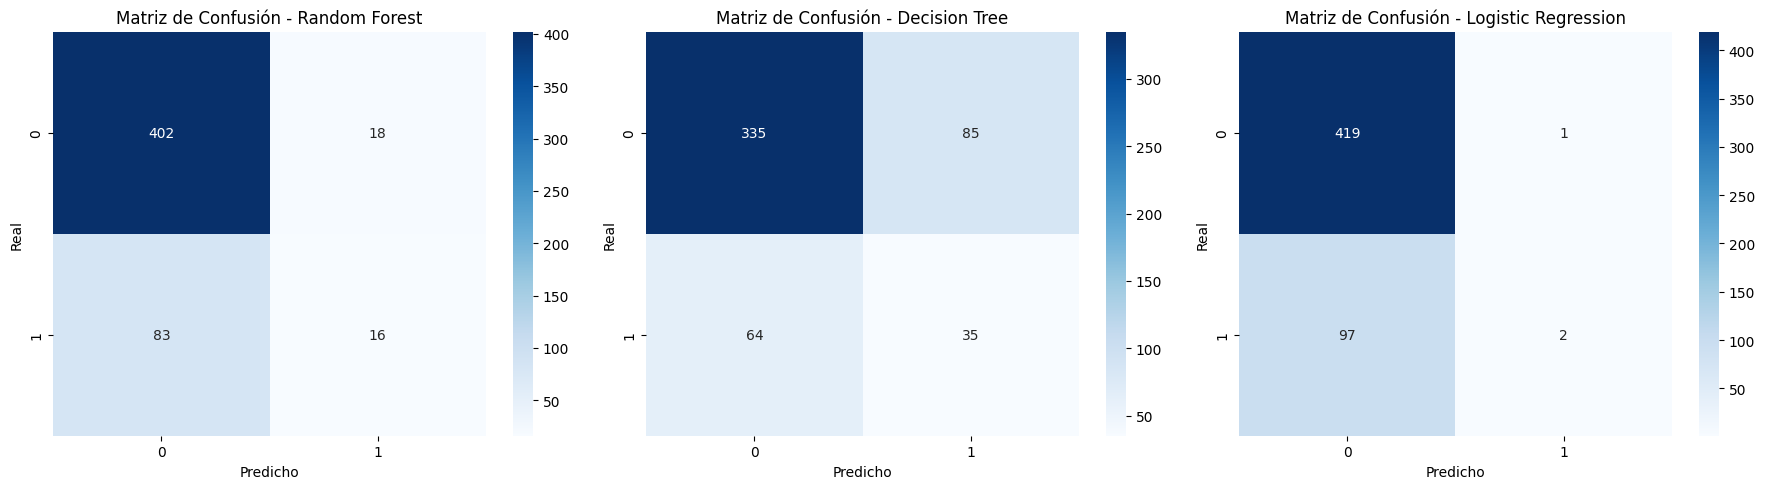

In [27]:
# Separar variables y objetivo
X = df.drop(columns=['Moroso'])
y = df['Moroso'].astype(int)

# Escalar solo para Logistic Regression
scaler = StandardScaler()
X_logistic = scaler.fit_transform(X)

# Modelos rápidos
modelos_rapidos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Separar para árboles y para regresión logística
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_logistic, y, test_size=0.2, random_state=42)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X, y, test_size=0.2, random_state=42)

resultados_rapidos = []

for nombre, modelo in modelos_rapidos.items():
    if nombre == 'Logistic Regression':
        modelo.fit(X_train_std, y_train_std)
        y_pred = modelo.predict(X_test_std)
    else:
        modelo.fit(X_train_tree, y_train_tree)
        y_pred = modelo.predict(X_test_tree)

    acc = accuracy_score(y_test_tree, y_pred)
    resultados_rapidos.append({
        'Modelo': nombre,
        'Accuracy': acc,
        'Reporte': classification_report(y_test_tree, y_pred, output_dict=True),
        'Matriz Confusión': confusion_matrix(y_test_tree, y_pred)
    })

# Crear DataFrame de resultados
resumen_rapidos = pd.DataFrame({
    'Modelo': [r['Modelo'] for r in resultados_rapidos],
    'Accuracy': [r['Accuracy'] for r in resultados_rapidos]
}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

display(resumen_rapidos)

# Crear DataFrame con métricas detalladas
metricas = []

for resultado in resultados_rapidos:
    reporte = resultado['Reporte']
    metricas.append({
        'Modelo': resultado['Modelo'],
        'Precision (Clase 1)': reporte['1']['precision'],
        'Recall (Clase 1)': reporte['1']['recall'],
        'F1-score (Clase 1)': reporte['1']['f1-score'],
        'Precision (Clase 0)': reporte['0']['precision'],
        'Recall (Clase 0)': reporte['0']['recall'],
        'F1-score (Clase 0)': reporte['0']['f1-score']
    })

df_metricas = pd.DataFrame(metricas).sort_values(by='F1-score (Clase 1)', ascending=False).reset_index(drop=True)

# Mostrar tabla de métricas
display(df_metricas)


# Visualizar matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, resultado in zip(axes, resultados_rapidos):
    cm = resultado['Matriz Confusión']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Matriz de Confusión - {resultado["Modelo"]}')
    ax.set_xlabel('Predicho')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.show()



DT es el que mejor está prediciendo los morosos (pero aún así con una eficacia baja)
De manera general RF predice mejor el global de casos

## Balanceo de las clases

### Undersampling

,Modelo,Accuracy
0,Logistic Regression,0.647959
1,Random Forest,0.637755
2,Decision Tree,0.622449


,Modelo,Precision (Clase 1),Recall (Clase 1),F1-score (Clase 1),Precision (Clase 0),Recall (Clase 0),F1-score (Clase 0)
0,Logistic Regression,0.663265,0.643564,0.653266,0.632653,0.652632,0.642487
1,Random Forest,0.656250,0.623762,0.639594,0.620000,0.652632,0.635897
2,Decision Tree,0.648352,0.584158,0.614583,0.600000,0.663158,0.630000


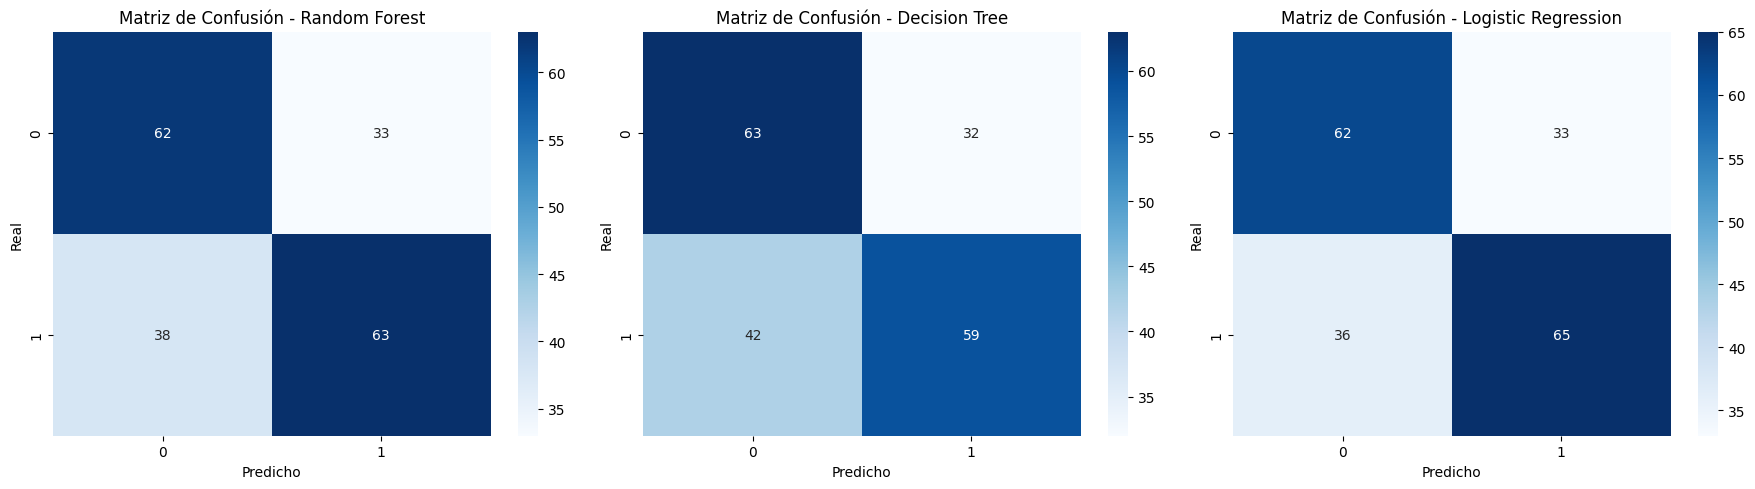

In [28]:
# Separar por clase
df_majority = df[df['Moroso'] == 0]
df_minority = df[df['Moroso'] == 1]

# Submuestreo de la mayoría
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

# Combinar
df_balanced = pd.concat([df_majority_downsampled, df_minority])
# Separar variables y objetivo
X = df_balanced.drop(columns=['Moroso'])
y = df_balanced['Moroso'].astype(int)

# Escalar solo para Logistic Regression
scaler = StandardScaler()
X_logistic = scaler.fit_transform(X)

# Modelos rápidos
modelos_rapidos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Separar para árboles y para regresión logística
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_logistic, y, test_size=0.2, random_state=42)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X, y, test_size=0.2, random_state=42)

resultados_rapidos_balanced = []

for nombre, modelo in modelos_rapidos.items():
    if nombre == 'Logistic Regression':
        modelo.fit(X_train_std, y_train_std)
        y_pred = modelo.predict(X_test_std)
    else:
        modelo.fit(X_train_tree, y_train_tree)
        y_pred = modelo.predict(X_test_tree)

    acc = accuracy_score(y_test_tree, y_pred)
    resultados_rapidos_balanced.append({
        'Modelo': nombre,
        'Accuracy': acc,
        'Reporte': classification_report(y_test_tree, y_pred, output_dict=True),
        'Matriz Confusión': confusion_matrix(y_test_tree, y_pred)
    })

# Crear DataFrame de resultados
resumen_rapidos_balanceados = pd.DataFrame({
    'Modelo': [r['Modelo'] for r in resultados_rapidos_balanced],
    'Accuracy': [r['Accuracy'] for r in resultados_rapidos_balanced]
}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

display(resumen_rapidos_balanceados)

# Crear DataFrame con métricas detalladas
metricas_balanceadas = []

for resultado in resultados_rapidos_balanced:
    reporte_balanceado = resultado['Reporte']
    metricas_balanceadas.append({
        'Modelo': resultado['Modelo'],
        'Precision (Clase 1)': reporte_balanceado['1']['precision'],
        'Recall (Clase 1)': reporte_balanceado['1']['recall'],
        'F1-score (Clase 1)': reporte_balanceado['1']['f1-score'],
        'Precision (Clase 0)': reporte_balanceado['0']['precision'],
        'Recall (Clase 0)': reporte_balanceado['0']['recall'],
        'F1-score (Clase 0)': reporte_balanceado['0']['f1-score']
    })

df_metricas_balanceadas = pd.DataFrame(metricas_balanceadas).sort_values(by='F1-score (Clase 1)', ascending=False).reset_index(drop=True)

# Mostrar tabla de métricas
display(df_metricas_balanceadas)

# Visualizar matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, resultado in zip(axes, resultados_rapidos_balanced):
    cm = resultado['Matriz Confusión']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Matriz de Confusión - {resultado["Modelo"]}')
    ax.set_xlabel('Predicho')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.show()


### Oversampling

In [29]:
#df.to_pickle('df.pkl')
#Extraer df para hacer smote por fuera 

#Codigo SMOTE por fuera

#from imblearn.over_sampling import SMOTE
#import pandas as pd
#df= pd.read_pickle('df.pkl')
#columnas_porcenatajes = ['% INSCRIPCION', '% DTO' ]
#for col in columnas_porcenatajes:
#    df[col] = df[col]*100
#for col in df.columns:
#    df[col] = df[col].round().astype(int)
#X = df.drop(columns=['Moroso'])
#y = df['Moroso'].astype(int)
#smote = SMOTE(random_state=42)
#X_res, y_res = smote.fit_resample(X, y)
#df_res = pd.concat([X_res, y_res], axis=1)
#df_res.to_pickle('df_res.pkl')

In [30]:
df_oversampled = pd.read_pickle('../data/df_res.pkl')

,Modelo,Accuracy
0,Random Forest,0.847981
1,Decision Tree,0.769596
2,Logistic Regression,0.707838


,Modelo,Precision (Clase 1),Recall (Clase 1),F1-score (Clase 1),Precision (Clase 0),Recall (Clase 0),F1-score (Clase 0)
0,Random Forest,0.835000,0.843434,0.839196,0.859729,0.852018,0.855856
1,Decision Tree,0.742788,0.780303,0.761084,0.795775,0.760090,0.777523
2,Logistic Regression,0.656904,0.792929,0.718535,0.774725,0.632287,0.696296


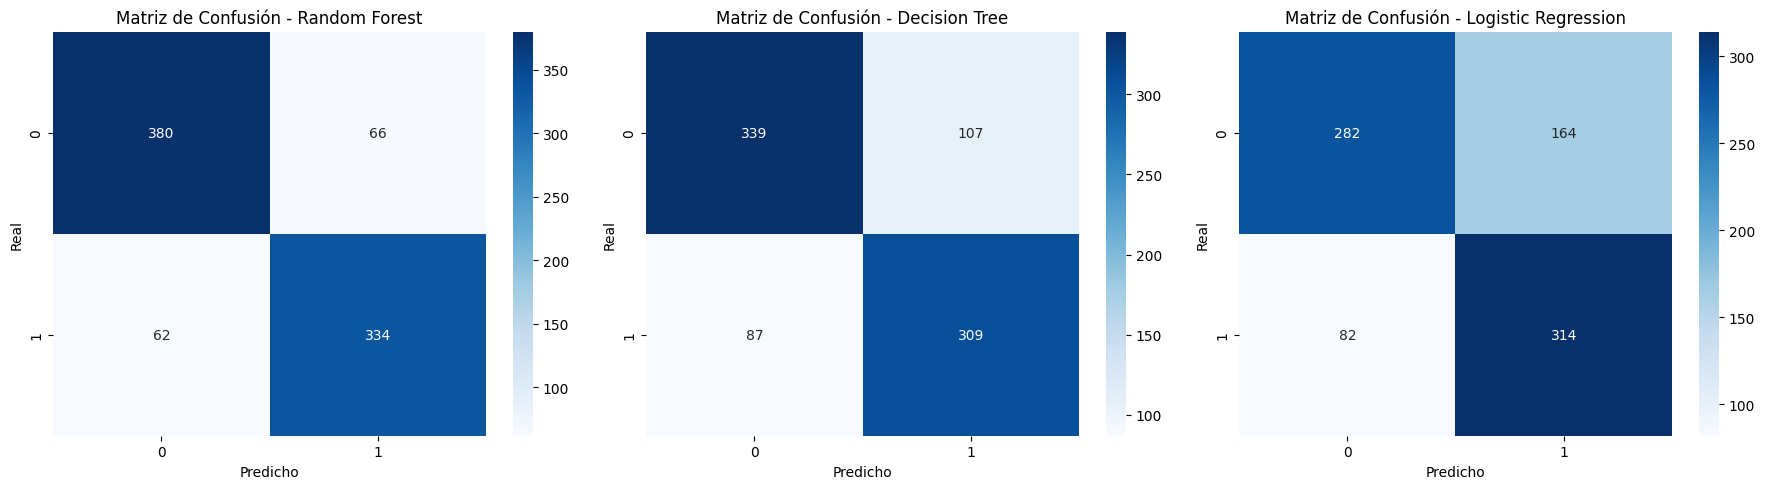

In [31]:
X = df_oversampled.drop(columns=['Moroso'])
y = df_oversampled['Moroso'].astype(int)

# Escalar solo para Logistic Regression
scaler = StandardScaler()
X_logistic = scaler.fit_transform(X)

# Modelos rápidos
modelos_rapidos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Separar para árboles y para regresión logística
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_logistic, y, test_size=0.2, random_state=42)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X, y, test_size=0.2, random_state=42)

resultados_rapidos_oversampled = []

for nombre, modelo in modelos_rapidos.items():
    if nombre == 'Logistic Regression':
        modelo.fit(X_train_std, y_train_std)
        y_pred = modelo.predict(X_test_std)
    else:
        modelo.fit(X_train_tree, y_train_tree)
        y_pred = modelo.predict(X_test_tree)

    acc = accuracy_score(y_test_tree, y_pred)
    resultados_rapidos_oversampled.append({
        'Modelo': nombre,
        'Accuracy': acc,
        'Reporte': classification_report(y_test_tree, y_pred, output_dict=True),
        'Matriz Confusión': confusion_matrix(y_test_tree, y_pred)
    })

# Crear DataFrame de resultados
resumen_rapidos_oversampled = pd.DataFrame({
    'Modelo': [r['Modelo'] for r in resultados_rapidos_oversampled],
    'Accuracy': [r['Accuracy'] for r in resultados_rapidos_oversampled]
}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

display(resumen_rapidos_oversampled)

# Crear DataFrame con métricas detalladas
metricas_oversampled = []

for resultado in resultados_rapidos_oversampled:
    reporte_oversampled = resultado['Reporte']
    metricas_oversampled.append({
        'Modelo': resultado['Modelo'],
        'Precision (Clase 1)': reporte_oversampled['1']['precision'],
        'Recall (Clase 1)': reporte_oversampled['1']['recall'],
        'F1-score (Clase 1)': reporte_oversampled['1']['f1-score'],
        'Precision (Clase 0)': reporte_oversampled['0']['precision'],
        'Recall (Clase 0)': reporte_oversampled['0']['recall'],
        'F1-score (Clase 0)': reporte_oversampled['0']['f1-score']
    })

df_metricas_oversampled = pd.DataFrame(metricas_oversampled).sort_values(by='F1-score (Clase 1)', ascending=False).reset_index(drop=True)

# Mostrar tabla de métricas
display(df_metricas_oversampled)

# Visualizar matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, resultado in zip(axes, resultados_rapidos_oversampled):
    cm = resultado['Matriz Confusión']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Matriz de Confusión - {resultado["Modelo"]}')
    ax.set_xlabel('Predicho')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.show()


*  Sacar grafico de DT
*  Ajustar Hiperparametros
*  Agrupar nacionalidaes


# ML preliminar con agrupación paises

## Limpieza

### DF con Agrupaciones de paises

In [32]:
#Selección de columnas relevantes
df_convo_deuda_ml_agrup=df_convo_deuda.copy().drop(columns= ['TIPOLOGIA MATRICULA', 'ID OPORTUNIDAD', 'ID NACS', 'FECHA PRODUCCIÓN', 'CONVOCATORIA', 'FECHA 1ra CUOTA', 'FECHA 1ra CUOTA ORIGINAL',
       '% Impagado Actual Vdo', 'Importe Impagado Actual', 'ID PROGRAMA', 'PRECIO CURSO', 'NACIONALIDAD',
       'PAÍS DE RESIDENCIA']) #Quizas mejores resultados con ID de programa

#Eliminar Nas
df_convo_deuda_ml_agrup.dropna(inplace=True)

### Preprocess

#### Seleccionar Dataframe

In [33]:
#df limpio
df = df_convo_deuda_ml_agrup.copy()

#### Label Encoders: Conversión categóricas para ML

In [34]:
#Seleccionar columnas categoricas
categorical_cols = df.select_dtypes(include=['category']).columns

# Diccionario para guardar los LabelEncoders
label_encoders = {}

# Aplicar LabelEncoder por columna
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Guardar el encoder para esa columna

## Entrenamiento rápido

,Modelo,Accuracy
0,Logistic Regression,0.811175
1,Random Forest,0.805395
2,Decision Tree,0.722543


,Modelo,Precision (Clase 1),Recall (Clase 1),F1-score (Clase 1),Precision (Clase 0),Recall (Clase 0),F1-score (Clase 0)
0,Decision Tree,0.293578,0.323232,0.307692,0.836585,0.816667,0.826506
1,Random Forest,0.464286,0.131313,0.204724,0.824847,0.964286,0.889133
2,Logistic Regression,0.666667,0.020202,0.039216,0.812016,0.997619,0.895299


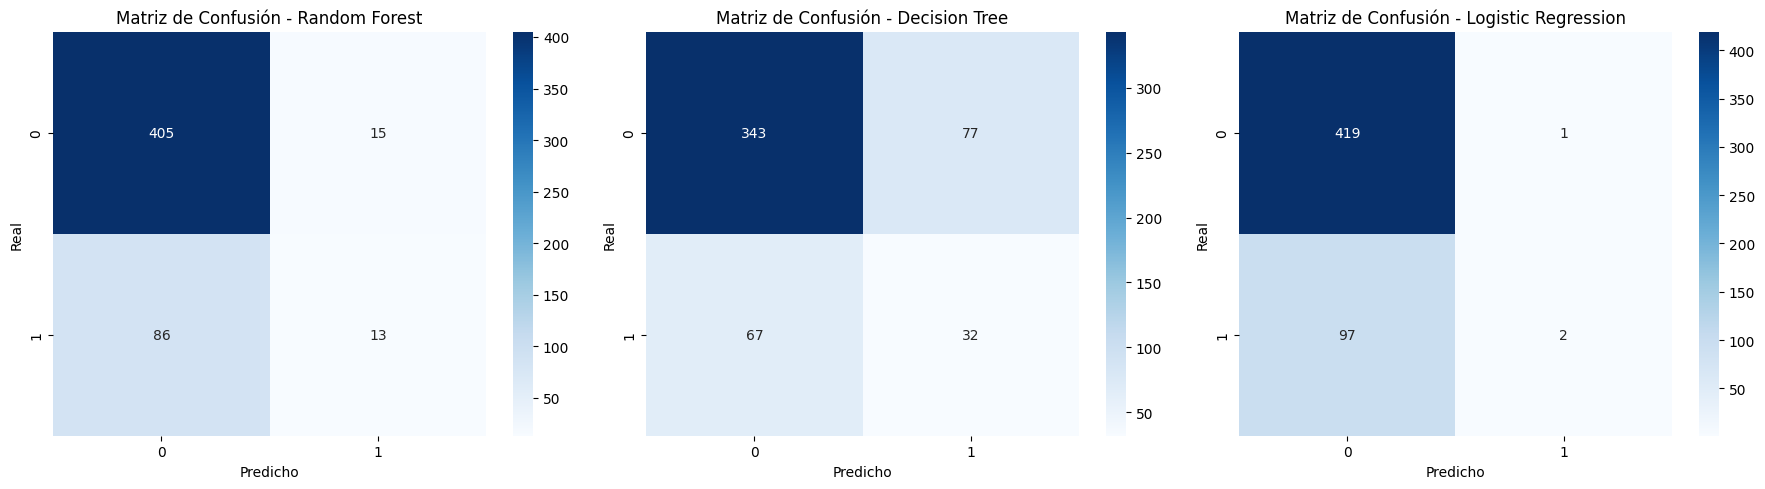

In [35]:
# Separar variables y objetivo
X = df.drop(columns=['Moroso'])
y = df['Moroso'].astype(int)

# Escalar solo para Logistic Regression
scaler = StandardScaler()
X_logistic = scaler.fit_transform(X)

# Modelos rápidos
modelos_rapidos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Separar para árboles y para regresión logística
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_logistic, y, test_size=0.2, random_state=42)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X, y, test_size=0.2, random_state=42)

resultados_rapidos = []

for nombre, modelo in modelos_rapidos.items():
    if nombre == 'Logistic Regression':
        modelo.fit(X_train_std, y_train_std)
        y_pred = modelo.predict(X_test_std)
    else:
        modelo.fit(X_train_tree, y_train_tree)
        y_pred = modelo.predict(X_test_tree)

    acc = accuracy_score(y_test_tree, y_pred)
    resultados_rapidos.append({
        'Modelo': nombre,
        'Accuracy': acc,
        'Reporte': classification_report(y_test_tree, y_pred, output_dict=True),
        'Matriz Confusión': confusion_matrix(y_test_tree, y_pred)
    })

# Crear DataFrame de resultados
resumen_rapidos = pd.DataFrame({
    'Modelo': [r['Modelo'] for r in resultados_rapidos],
    'Accuracy': [r['Accuracy'] for r in resultados_rapidos]
}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

display(resumen_rapidos)

# Crear DataFrame con métricas detalladas
metricas = []

for resultado in resultados_rapidos:
    reporte = resultado['Reporte']
    metricas.append({
        'Modelo': resultado['Modelo'],
        'Precision (Clase 1)': reporte['1']['precision'],
        'Recall (Clase 1)': reporte['1']['recall'],
        'F1-score (Clase 1)': reporte['1']['f1-score'],
        'Precision (Clase 0)': reporte['0']['precision'],
        'Recall (Clase 0)': reporte['0']['recall'],
        'F1-score (Clase 0)': reporte['0']['f1-score']
    })

df_metricas = pd.DataFrame(metricas).sort_values(by='F1-score (Clase 1)', ascending=False).reset_index(drop=True)

# Mostrar tabla de métricas
display(df_metricas)


# Visualizar matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, resultado in zip(axes, resultados_rapidos):
    cm = resultado['Matriz Confusión']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Matriz de Confusión - {resultado["Modelo"]}')
    ax.set_xlabel('Predicho')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.show()



## Balanceo de las clases

### Undersampling

,Modelo,Accuracy
0,Random Forest,0.673469
1,Logistic Regression,0.637755
2,Decision Tree,0.622449


,Modelo,Precision (Clase 1),Recall (Clase 1),F1-score (Clase 1),Precision (Clase 0),Recall (Clase 0),F1-score (Clase 0)
0,Random Forest,0.679612,0.693069,0.686275,0.666667,0.652632,0.659574
1,Logistic Regression,0.650000,0.643564,0.646766,0.625000,0.631579,0.628272
2,Decision Tree,0.645161,0.594059,0.618557,0.601942,0.652632,0.626263


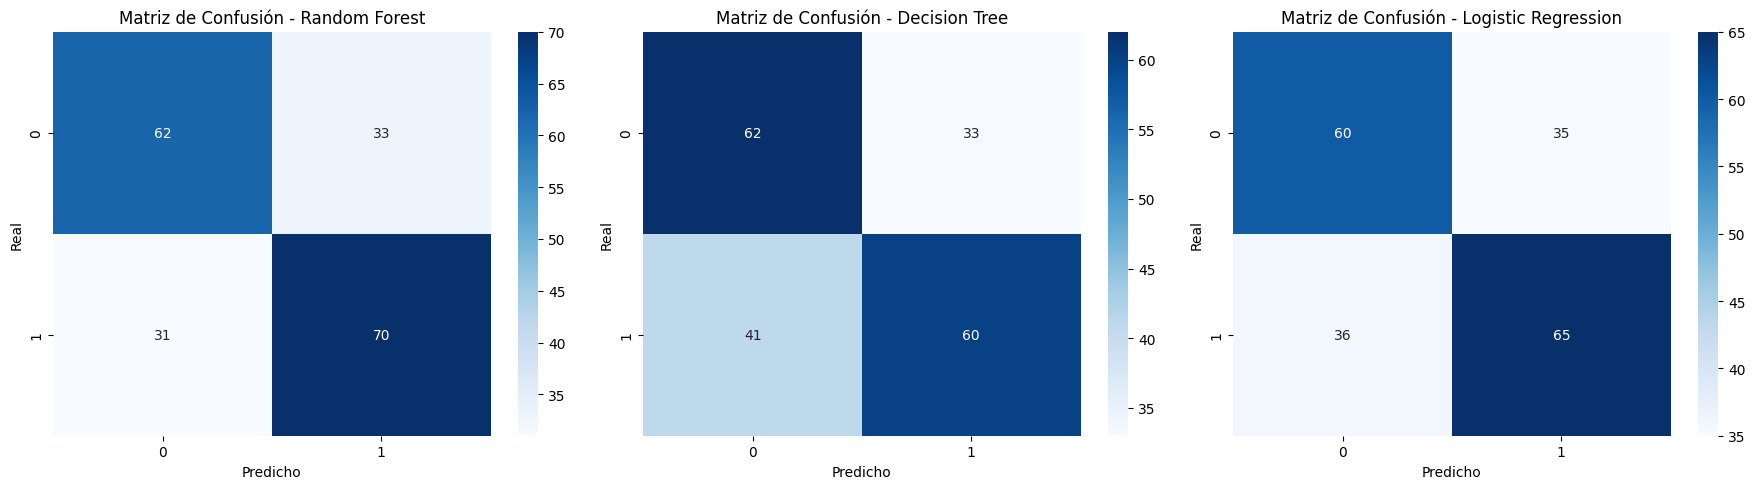

In [36]:
# Separar por clase
df_majority = df[df['Moroso'] == 0]
df_minority = df[df['Moroso'] == 1]

# Submuestreo de la mayoría
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

# Combinar
df_balanced = pd.concat([df_majority_downsampled, df_minority])
# Separar variables y objetivo
X = df_balanced.drop(columns=['Moroso'])
y = df_balanced['Moroso'].astype(int)

# Escalar solo para Logistic Regression
scaler = StandardScaler()
X_logistic = scaler.fit_transform(X)

# Modelos rápidos
modelos_rapidos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Separar para árboles y para regresión logística
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_logistic, y, test_size=0.2, random_state=42)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X, y, test_size=0.2, random_state=42)

resultados_rapidos_balanced = []

for nombre, modelo in modelos_rapidos.items():
    if nombre == 'Logistic Regression':
        modelo.fit(X_train_std, y_train_std)
        y_pred = modelo.predict(X_test_std)
    else:
        modelo.fit(X_train_tree, y_train_tree)
        y_pred = modelo.predict(X_test_tree)

    acc = accuracy_score(y_test_tree, y_pred)
    resultados_rapidos_balanced.append({
        'Modelo': nombre,
        'Accuracy': acc,
        'Reporte': classification_report(y_test_tree, y_pred, output_dict=True),
        'Matriz Confusión': confusion_matrix(y_test_tree, y_pred)
    })

# Crear DataFrame de resultados
resumen_rapidos_balanceados = pd.DataFrame({
    'Modelo': [r['Modelo'] for r in resultados_rapidos_balanced],
    'Accuracy': [r['Accuracy'] for r in resultados_rapidos_balanced]
}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

display(resumen_rapidos_balanceados)

# Crear DataFrame con métricas detalladas
metricas_balanceadas = []

for resultado in resultados_rapidos_balanced:
    reporte_balanceado = resultado['Reporte']
    metricas_balanceadas.append({
        'Modelo': resultado['Modelo'],
        'Precision (Clase 1)': reporte_balanceado['1']['precision'],
        'Recall (Clase 1)': reporte_balanceado['1']['recall'],
        'F1-score (Clase 1)': reporte_balanceado['1']['f1-score'],
        'Precision (Clase 0)': reporte_balanceado['0']['precision'],
        'Recall (Clase 0)': reporte_balanceado['0']['recall'],
        'F1-score (Clase 0)': reporte_balanceado['0']['f1-score']
    })

df_metricas_balanceadas = pd.DataFrame(metricas_balanceadas).sort_values(by='F1-score (Clase 1)', ascending=False).reset_index(drop=True)

# Mostrar tabla de métricas
display(df_metricas_balanceadas)

# Visualizar matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, resultado in zip(axes, resultados_rapidos_balanced):
    cm = resultado['Matriz Confusión']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Matriz de Confusión - {resultado["Modelo"]}')
    ax.set_xlabel('Predicho')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.show()


### Oversampling

In [37]:
#df.to_pickle('df_agg.pkl')
#Extraer df para hacer smote por fuera 

#Codigo SMOTE por fuera

#from imblearn.over_sampling import SMOTE
#import pandas as pd
#df= pd.read_pickle('df_agg.pkl')
#columnas_porcenatajes = ['% INSCRIPCION', '% DTO' ]
#for col in columnas_porcenatajes:
#    df[col] = df[col]*100
#for col in df.columns:
#    df[col] = df[col].round().astype(int)
#X = df.drop(columns=['Moroso'])
#y = df['Moroso'].astype(int)
#smote = SMOTE(random_state=42)
#X_res, y_res = smote.fit_resample(X, y)
#df_res = pd.concat([X_res, y_res], axis=1)
#df_res.to_pickle('df_res_agg.pkl')

In [38]:
df_oversampled = pd.read_pickle('../data/df_res_agg.pkl')

,Modelo,Accuracy
0,Random Forest,0.849169
1,Decision Tree,0.794537
2,Logistic Regression,0.706651


,Modelo,Precision (Clase 1),Recall (Clase 1),F1-score (Clase 1),Precision (Clase 0),Recall (Clase 0),F1-score (Clase 0)
0,Random Forest,0.832099,0.851010,0.841448,0.864989,0.847534,0.856172
1,Decision Tree,0.775309,0.792929,0.784020,0.812357,0.795964,0.804077
2,Logistic Regression,0.657505,0.785354,0.715765,0.769648,0.636771,0.696933


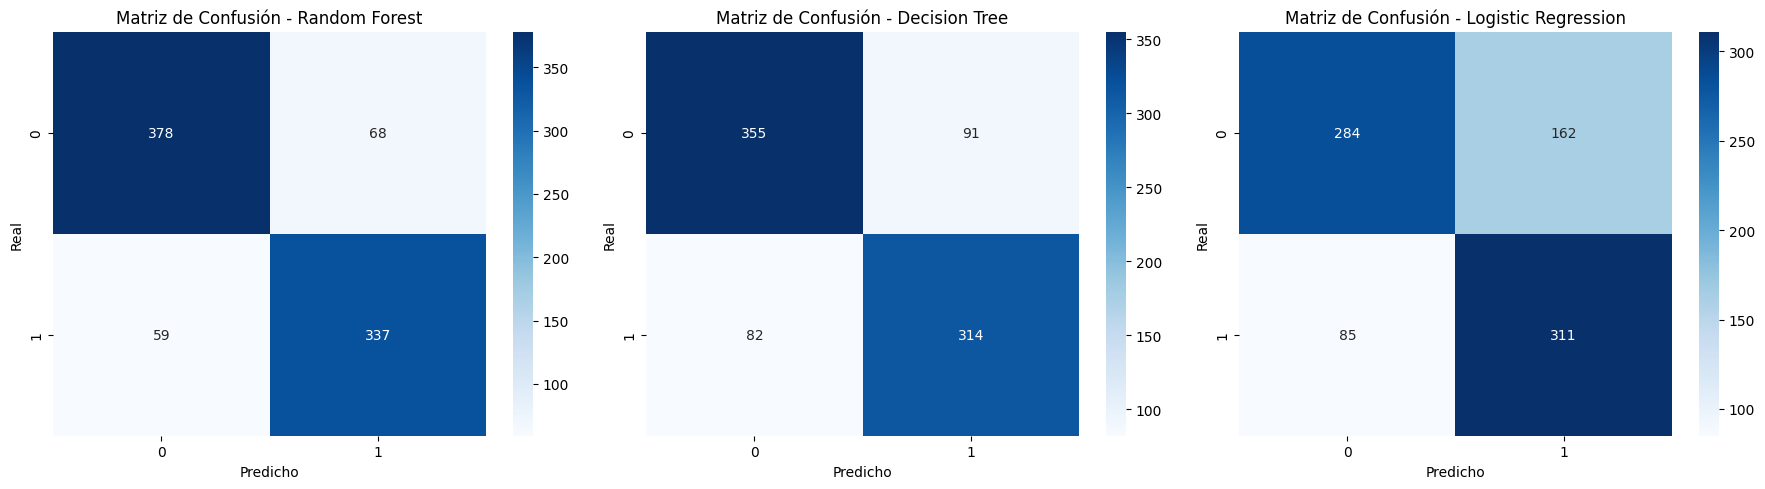

In [39]:
X = df_oversampled.drop(columns=['Moroso'])
y = df_oversampled['Moroso'].astype(int)

# Escalar solo para Logistic Regression
scaler = StandardScaler()
X_logistic = scaler.fit_transform(X)

# Modelos rápidos
modelos_rapidos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Separar para árboles y para regresión logística
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_logistic, y, test_size=0.2, random_state=42)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X, y, test_size=0.2, random_state=42)

resultados_rapidos_oversampled = []

for nombre, modelo in modelos_rapidos.items():
    if nombre == 'Logistic Regression':
        modelo.fit(X_train_std, y_train_std)
        y_pred = modelo.predict(X_test_std)
    else:
        modelo.fit(X_train_tree, y_train_tree)
        y_pred = modelo.predict(X_test_tree)

    acc = accuracy_score(y_test_tree, y_pred)
    resultados_rapidos_oversampled.append({
        'Modelo': nombre,
        'Accuracy': acc,
        'Reporte': classification_report(y_test_tree, y_pred, output_dict=True),
        'Matriz Confusión': confusion_matrix(y_test_tree, y_pred)
    })

# Crear DataFrame de resultados
resumen_rapidos_oversampled = pd.DataFrame({
    'Modelo': [r['Modelo'] for r in resultados_rapidos_oversampled],
    'Accuracy': [r['Accuracy'] for r in resultados_rapidos_oversampled]
}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

display(resumen_rapidos_oversampled)

# Crear DataFrame con métricas detalladas
metricas_oversampled = []

for resultado in resultados_rapidos_oversampled:
    reporte_oversampled = resultado['Reporte']
    metricas_oversampled.append({
        'Modelo': resultado['Modelo'],
        'Precision (Clase 1)': reporte_oversampled['1']['precision'],
        'Recall (Clase 1)': reporte_oversampled['1']['recall'],
        'F1-score (Clase 1)': reporte_oversampled['1']['f1-score'],
        'Precision (Clase 0)': reporte_oversampled['0']['precision'],
        'Recall (Clase 0)': reporte_oversampled['0']['recall'],
        'F1-score (Clase 0)': reporte_oversampled['0']['f1-score']
    })

df_metricas_oversampled = pd.DataFrame(metricas_oversampled).sort_values(by='F1-score (Clase 1)', ascending=False).reset_index(drop=True)

# Mostrar tabla de métricas
display(df_metricas_oversampled)

# Visualizar matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, resultado in zip(axes, resultados_rapidos_oversampled):
    cm = resultado['Matriz Confusión']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Matriz de Confusión - {resultado["Modelo"]}')
    ax.set_xlabel('Predicho')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.show()


In [40]:
df_convo_deuda_ml.columns

Index(['TIPOLOGIA ALUMNO', 'DIA CERO', 'FACTURACIÓN NETA',
       'IMPORTE INSCRIPCIÓN', '% INSCRIPCION', 'MEDIO PAGO PI',
       'IMPORTE PENDIENTE PAGO', 'MEDIO PAGO IMPORTE PENDIENTE',
       'NUMERO DE CUOTAS', 'FORMA DE PAGO', 'ASESOR', 'FORMA DE PAGO ORIGINAL',
       'TIPO PROGRAMA', 'NACIONALIDAD', 'PAÍS DE RESIDENCIA',
       'MANTIENE MEDIO PAGO', 'DIFERENCIA FECHA 1ra CUOTA - ORIGINAL',
       'DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA', '% DTO', 'Moroso',
       'DIFERENCIA PI vs. IMPORTE PTE'],
      dtype='object')

Mejora Decision Tree pero empeora Random Forest. Y este último (RF) sigue siendo el mejor

# EDA pt. 2

## Gráficos % PI

### %PI - Facturación Neta - Importe impagado Vdo - Importe cobrado

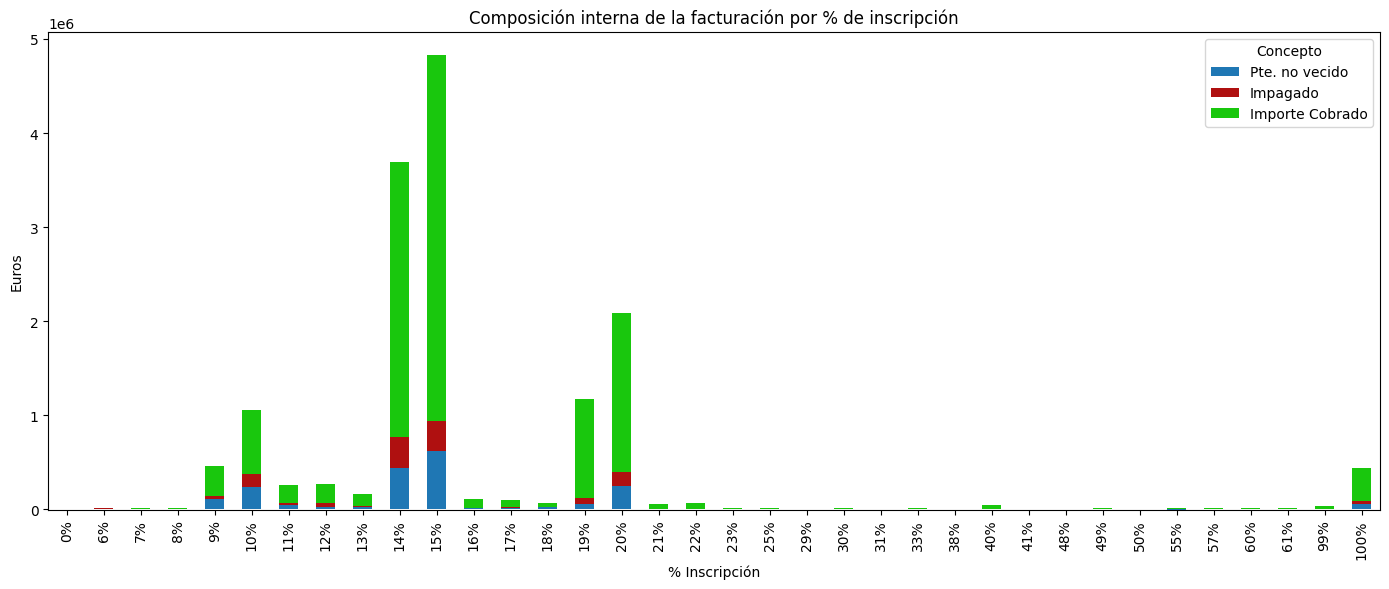

In [ ]:
#importe VDO y importe impagado actual
df_convo_deuda_2 = pd.merge(df_convo, df_deuda[['Moroso',
       '% Impagado Actual Vdo', 'Importe Impagado Actual', 'Importe Cobrado']], how='left', left_on='ID NACS', right_index=True)
df_graff = df_convo_deuda_2[['% INSCRIPCION', 'FACTURACIÓN NETA', 'Importe Impagado Actual', 'Importe Cobrado' ]].copy()


# Asegurar formato correcto
df_graff['% INSCRIPCION'] = pd.to_numeric(df_graff['% INSCRIPCION'], errors='coerce')*100

# Crear tramos del 1%
df_graff['TRAMO % INSCRIPCION'] = pd.cut(df_graff['% INSCRIPCION'],
                                         bins=range(0, 102, 1),
                                         right=False,
                                         labels=[f"{i}%" for i in range(0, 101)])

# Agrupar por tramo y sumar facturación e impagado
df_grouped = df_graff.groupby('TRAMO % INSCRIPCION')[
    ['FACTURACIÓN NETA', 'Importe Impagado Actual', 'Importe Cobrado']
].sum()

# Eliminar tramos sin datos
df_grouped = df_grouped[(df_grouped.T != 0).any()]

# Calcular lo pagado (facturación - impagado)
df_grouped['Facturación Neta'] = df_grouped['FACTURACIÓN NETA'] - df_grouped['Importe Impagado Actual'] - df_grouped['Importe Cobrado']
df_grouped['%II'] = df_grouped['Importe Impagado Actual']/(df_grouped['Importe Impagado Actual'] + df_grouped['Importe Cobrado'])*100

# Preparar datos para gráfico (en orden: lo que va abajo primero)
df_plot = df_grouped[['Facturación Neta', 'Importe Impagado Actual', 'Importe Cobrado']]

# Graficar
df_plot.plot(kind='bar', stacked=True, figsize=(14, 6), color=['#1f77b4', "#AF1010", "#19c70d"])

plt.title('Composición interna de la facturación por % de inscripción')
plt.ylabel('Euros')
plt.xlabel('% Inscripción')
plt.legend(title='Concepto', labels=['Pte. no vecido', 'Impagado vencido', 'Importe Cobrado'])
plt.tight_layout()
plt.show()


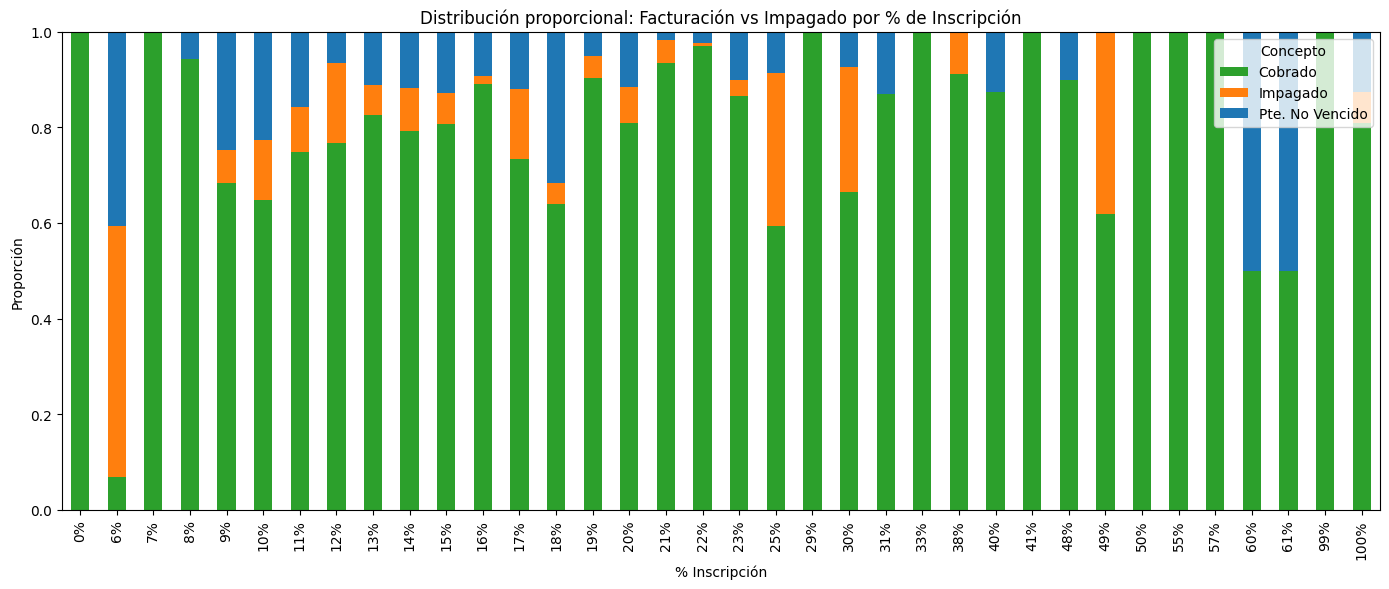

In [42]:
# Copiar datos
df_graff = df_convo_deuda_2[['% INSCRIPCION', 'FACTURACIÓN NETA', 'Importe Impagado Actual', 'Importe Cobrado']].copy()

# Asegurar formato numérico (y convertir a %)
df_graff['% INSCRIPCION'] = pd.to_numeric(df_graff['% INSCRIPCION'], errors='coerce') * 100

# Crear tramos del 1%
df_graff['TRAMO % INSCRIPCION'] = pd.cut(df_graff['% INSCRIPCION'], 
                                         bins=range(0, 102, 1),
                                         right=False,
                                         labels=[f"{i}%" for i in range(0, 101)])

# Agrupar por tramo y sumar
df_plot = df_graff.groupby('TRAMO % INSCRIPCION')[
    ['FACTURACIÓN NETA', 'Importe Impagado Actual', 'Importe Cobrado']
].sum()

# Eliminar tramos sin datos
df_plot = df_plot[(df_plot.T != 0).any()]

# Calcular Pte. No Vencido
df_plot['Pte. No Vencido'] = df_plot['FACTURACIÓN NETA'] - df_plot['Importe Cobrado'] - df_plot['Importe Impagado Actual']

# Asegurar que no haya negativos por errores de redondeo o incoherencias
df_plot['Pte. No Vencido'] = df_plot['Pte. No Vencido'].clip(lower=0)

# Crear nuevo DataFrame con las tres columnas deseadas (en orden de apilado)
df_plot_final = df_plot[['Importe Cobrado', 'Importe Impagado Actual', 'Pte. No Vencido']]

# Normalizar (cada fila suma 1)
df_plot_prop = df_plot_final.div(df_plot_final.sum(axis=1), axis=0)

# Graficar
df_plot_prop.plot(kind='bar', stacked=True, figsize=(14, 6), color=['#2ca02c', '#ff7f0e', '#1f77b4'])

plt.title('Distribución proporcional: Facturación vs Impagado por % de Inscripción')
plt.ylabel('Proporción')
plt.xlabel('% Inscripción')
plt.legend(title='Concepto', labels=['Cobrado', 'Impagado', 'Pte. No Vencido'], loc='upper right')
plt.tight_layout()
plt.show()

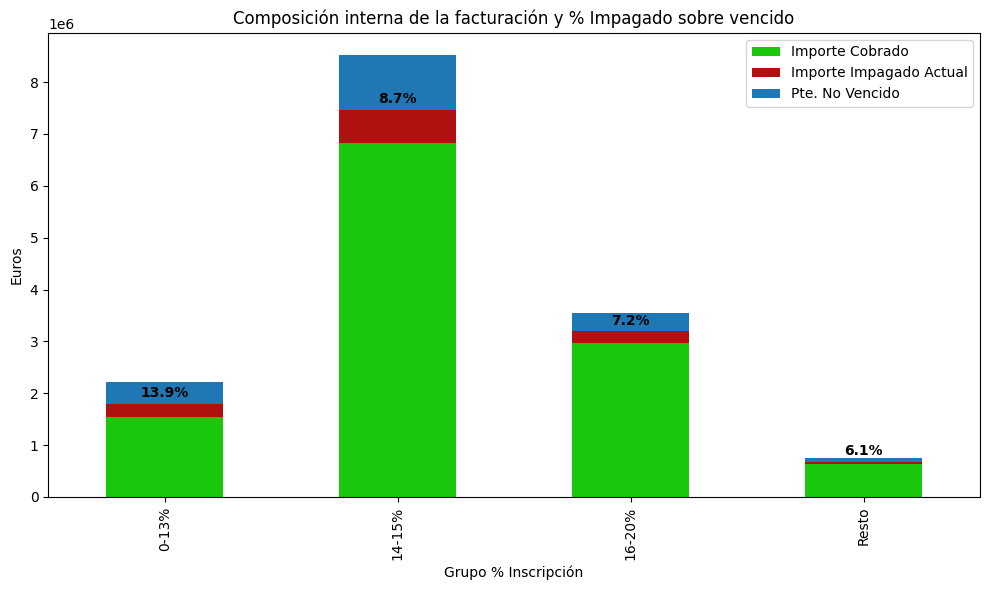

In [43]:
#importe VDO y importe impagado actual
df_convo_deuda_2 = pd.merge(df_convo, df_deuda[['Moroso',
       '% Impagado Actual Vdo', 'Importe Impagado Actual', 'Importe Cobrado']], how='left', left_on='ID NACS', right_index=True)
df_graff = df_convo_deuda_2[['% INSCRIPCION', 'FACTURACIÓN NETA', 'Importe Impagado Actual', 'Importe Cobrado' ]].copy()


# Asegurar formato correcto
df_graff['% INSCRIPCION'] = pd.to_numeric(df_graff['% INSCRIPCION'], errors='coerce')*100

# Crear tramos del 1%
df_graff['TRAMO % INSCRIPCION'] = pd.cut(df_graff['% INSCRIPCION'],
                                         bins=range(0, 102, 1),
                                         right=False,
                                         labels=[f"{i}%" for i in range(0, 101)])

# Agrupar por tramo y sumar facturación e impagado
df_grouped = df_graff.groupby('TRAMO % INSCRIPCION')[
    ['FACTURACIÓN NETA', 'Importe Impagado Actual', 'Importe Cobrado']
].sum()

# Eliminar tramos sin datos
df_grouped = df_grouped[(df_grouped.T != 0).any()]
df_grouped_custom = df_grouped.copy()

# Convertir índice '15%', '16%', etc. a número entero
df_grouped_custom['tramo_numerico'] = df_grouped_custom.index.str.replace('%', '').astype(int)

# Crear nueva columna de agrupación personalizada
def agrupar_tramo(tramo):
    if tramo < 14:
        return '0-13%'
    elif 14 <= tramo < 16:
        return '14-15%'
    elif 16 <= tramo <= 20:
        return '16-20%'
    else:
        return 'Resto'

df_grouped_custom['GRUPO PERSONALIZADO'] = df_grouped_custom['tramo_numerico'].apply(agrupar_tramo)
df_grouped_custom.drop(columns=['tramo_numerico'], inplace = True)
# Agrupar por grupo personalizado
df2 = df_grouped_custom.groupby('GRUPO PERSONALIZADO')[
    ['FACTURACIÓN NETA', 'Importe Impagado Actual', 'Importe Cobrado']
].sum()

# Calcular parte pendiente no vencida
df2['Pte. No Vencido'] = df2['FACTURACIÓN NETA'] - df2['Importe Impagado Actual'] - df2['Importe Cobrado']
df2['Pte. No Vencido'] = df2['Pte. No Vencido'].clip(lower=0)




# Calcular proporción de impagado sobre lo vencido
df2['% Impagado VDO'] = df2['Importe Impagado Actual'] / (df2['Importe Impagado Actual'] + df2['Importe Cobrado'])
df2['% Impagado VDO'] = df2['% Impagado VDO'].fillna(0)  # Por si hay división por cero

# Redondear para etiquetas
df2['% Impagado VDO Texto'] = (df2['% Impagado VDO'] * 100).round(1).astype(str) + '%'

# Preparar datos para gráfico apilado
df_plot = df2[['Importe Cobrado', 'Importe Impagado Actual', 'Pte. No Vencido']]

# Ordenar índice si es necesario
orden = ['0-13%', '14-15%', '16-20%', 'Resto']
df_plot = df_plot.loc[orden]
df2 = df2.loc[orden]  # mantener coherencia para etiquetas

# Graficar
import matplotlib.pyplot as plt

ax = df_plot.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#19c70d', '#AF1010', '#1f77b4'])

# Añadir etiquetas de % impagado sobre las barras
for i, val in enumerate(df2['% Impagado VDO Texto']):
    y = df_plot.iloc[i, 0] + df_plot.iloc[i, 1]  # Posición sobre la parte vencida (cobrado + impagado)
    ax.text(i, y + df_plot.max().max() * 0.01, val, ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Composición interna de la facturación y % Impagado sobre vencido')
plt.ylabel('Euros')
plt.xlabel('Grupo % Inscripción')
plt.tight_layout()
plt.show()

##  Análisis estadístico

### Correlación Morosidad ~ Variables categóricas

In [44]:
#seleccionar variables categoricas
list_corr_cat = []
df_categoricas = df_convo_deuda.select_dtypes(include='category')
#Ver las correlaciones de las variables categoricas
for cat in df_categoricas.drop(columns='Moroso').columns:
    var1, var2, chi2, p, V = calcular_independencia_categoricas(df_convo_deuda, cat, 'Moroso')
    list_corr_cat.append([var1, var2, chi2, p, V])
df_correlacion_cat = pd.DataFrame(list_corr_cat, columns=['var1', 'var2', 'chi2', 'p', 'V'])

#Ver resultados
print('*'*100)
print('*'*100)
print(f'{len (df_correlacion_cat[df_correlacion_cat['p'] < 0.05].sort_values('V', ascending=False))} de las {len(df_correlacion_cat)} variables categoricas son significativas para la morosidad')
print('Ordenadas según su fuerza de asociación por el estadístico V de Cramer:')
display(df_correlacion_cat[df_correlacion_cat['p'] < 0.05].sort_values('V', ascending=False))

****************************************************************************************************
****************************************************************************************************
11 de las 16 variables categoricas son significativas para la morosidad
Ordenadas según su fuerza de asociación por el estadístico V de Cramer:


,var1,var2,chi2,p,V
8,FORMA DE PAGO,Moroso,108.554569,2.245876e-23,0.204529
10,FORMA DE PAGO ORIGINAL,Moroso,82.827112,2.147988e-16,0.178656
13,PAÍS DE RESIDENCIA,Moroso,115.849940,2.884636e-05,0.172929
5,ID PROGRAMA,Moroso,96.046485,7.401950e-03,0.157457
6,MEDIO PAGO PI,Moroso,63.072311,3.415909e-10,0.155902
12,NACIONALIDAD,Moroso,92.847500,3.237712e-03,0.154872
15,AGRUPACION PAÍS DE RESIDENCIA,Moroso,57.537824,1.056154e-08,0.121870
7,MEDIO PAGO IMPORTE PENDIENTE,Moroso,40.885808,2.838202e-08,0.102732
14,AGRUPACION NACIONALIDAD,Moroso,39.848115,1.802061e-05,0.101459
1,TIPOLOGIA ALUMNO,Moroso,24.310029,5.261920e-06,0.096789


In [45]:
#seleccionar variables boleanas
list_corr_bool = []
df_bool = df_convo_deuda.select_dtypes(include='bool')
#Ver las correlaciones de las variables categoricas
for var in df_bool.columns:
    var1, var2, chi2, p, V = calcular_independencia_categoricas(df_convo_deuda, var, 'Moroso')
    list_corr_bool.append([var1, var2, chi2, p, V])
df_correlacion_bool = pd.DataFrame(list_corr_bool, columns=['var1', 'var2', 'chi2', 'p', 'V'])

#Ver resultados
print('*'*100)
print('*'*100)
print(f'{len (df_correlacion_bool[df_correlacion_bool['p'] < 0.05].sort_values('V', ascending=False))} de las {len(df_correlacion_bool)} variables boleanas son significativas para la morosidad')
print('Ordenadas según su fuerza de asociación por el estadístico V de Cramer:')
display(df_correlacion_bool[df_correlacion_bool['p'] < 0.05].sort_values('V', ascending=False))

****************************************************************************************************
****************************************************************************************************
2 de las 2 variables boleanas son significativas para la morosidad
Ordenadas según su fuerza de asociación por el estadístico V de Cramer:


,var1,var2,chi2,p,V
0,MANTIENE MEDIO PAGO,Moroso,29.74461,4.928748e-08,0.087624
1,DIFERENCIA PI vs. IMPORTE PTE,Moroso,29.74461,4.928748e-08,0.087624


# ESTRUCTURAR RESULTADOS

In [46]:
list_corr_num = []


df_num = df_convo_deuda.select_dtypes(include='number')
for col in df_num.columns:
    p, p_var, metodo, stat, p_test = prueba_comparacion_2grupos_variable(df_num[col], df_convo_deuda['Moroso'])
    list_corr_num.append([col, p, p_var, metodo, stat, p_test ])

df_correlacion_num = pd.DataFrame(list_corr_num, columns=['col', 'p Shapiro-Wilk ', 'p Levene', 'metodo', 'stat', 'p_test'])



c:\Users\ujgpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ujgpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [47]:
df_correlacion_num[df_correlacion_num['p_test'] < 0.05].sort_values('p_test', ascending=False)

,col,p Shapiro-Wilk,p Levene,metodo,stat,p_test
8,DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA,8.393549e-34,2.421363e-07,Mann-Whitney,1143508.0,4.763140e-02
9,% DTO,6.683326e-04,7.131113e-01,Mann-Whitney,553271.5,1.389700e-02
2,FACTURACIÓN NETA,3.683034e-30,8.416980e-01,Mann-Whitney,478953.5,1.188751e-02
0,ID NACS,1.103986e-49,6.615998e-01,Mann-Whitney,1107323.0,1.202926e-03
4,% INSCRIPCION,4.815200e-39,1.661074e-01,Mann-Whitney,566125.5,9.038265e-04
5,IMPORTE PENDIENTE PAGO,4.503283e-29,3.536211e-01,Mann-Whitney,459330.0,1.298218e-04
6,NUMERO DE CUOTAS,6.853391e-29,1.916659e-21,Mann-Whitney,410767.0,4.697733e-13
10,% Impagado Actual Vdo,4.831190e-25,0.000000e+00,Mann-Whitney,0.0,0.000000e+00
11,Importe Impagado Actual,4.793505e-26,0.000000e+00,Mann-Whitney,0.0,0.000000e+00


In [ ]:
variables_significativas = list(df_correlacion_cat[df_correlacion_cat['p'] < 0.05]['var1']) + list(df_correlacion_bool[df_correlacion_bool['p'] < 0.05]['var1']) + list(df_correlacion_num[df_correlacion_num['p_test'] < 0.05]['col'])

In [49]:
df_correlacion_num.sort_values('effect_size', ascending=False)

KeyError: 'effect_size'

In [ ]:
variables_significativas

['TIPOLOGIA ALUMNO',
 'CONVOCATORIA',
 'ID PROGRAMA',
 'MEDIO PAGO PI',
 'MEDIO PAGO IMPORTE PENDIENTE',
 'FORMA DE PAGO',
 'FORMA DE PAGO ORIGINAL',
 'NACIONALIDAD',
 'PAÍS DE RESIDENCIA',
 'AGRUPACION NACIONALIDAD',
 'AGRUPACION PAÍS DE RESIDENCIA',
 'MANTIENE MEDIO PAGO',
 'DIFERENCIA PI vs. IMPORTE PTE',
 'ID NACS',
 'FACTURACIÓN NETA',
 '% INSCRIPCION',
 'IMPORTE PENDIENTE PAGO',
 'NUMERO DE CUOTAS',
 'DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA',
 '% DTO',
 '% Impagado Actual Vdo',
 'Importe Impagado Actual']

In [ ]:
def cohens_d(grupo1, grupo2):
    n1, n2 = len(grupo1), len(grupo2)
    s1, s2 = grupo1.std(ddof=1), grupo2.std(ddof=1)
    s_pooled = np.sqrt(((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / (n1 + n2 - 2))
    d = (grupo1.mean() - grupo2.mean()) / s_pooled
    return d

def r_mannwhitney(u_stat, n1, n2):
    z = (u_stat - (n1 * n2) / 2) / np.sqrt((n1 * n2 * (n1 + n2 + 1)) / 12)
    r = abs(z) / np.sqrt(n1 + n2)
    return r

def prueba_comparacion_2grupos_variable(df_num_col, variable_grupo, alpha=0.05):
    df_temp = df_num_col.to_frame(name='valor')
    df_temp['grupo'] = variable_grupo

    grupos_unicos = df_temp['grupo'].dropna().unique()
    if len(grupos_unicos) != 2:
        print(f"⚠️ La variable de grupo no tiene exactamente 2 categorías: {grupos_unicos}")
        return

    grupos = [(str(g), df_temp[df_temp['grupo'] == g]['valor'].dropna()) for g in grupos_unicos]

    print(f"\n📊 Variable: {df_num_col.name}")
    normalidad = {}
    
    print("▶ PRUEBA DE NORMALIDAD (Shapiro-Wilk):")
    for name, values in grupos:
        stat, p = shapiro(values)
        normal = p >= alpha
        normalidad[name] = normal
        print(f"  - Grupo {name}: p = {p:.3f} → {'Normal' if normal else 'No normal'}")

    print("▶ PRUEBA DE IGUALDAD DE VARIANZAS (Levene):")
    stat, p_var = levene(*[g for _, g in grupos])
    iguales_varianzas = p_var >= alpha
    print(f"  - p = {p_var:.3f} → {'Homogéneas' if iguales_varianzas else 'Diferentes'} varianzas")

    todos_normales = all(normalidad.values())

    print("▶ PRUEBA DE DIFERENCIAS ENTRE GRUPOS:")
    grupo1 = grupos[0][1]
    grupo2 = grupos[1][1]

    if todos_normales:
        t_stat, p_test = ttest_ind(grupo1, grupo2, equal_var=iguales_varianzas)
        print(f"  - t-test {'(igual varianza)' if iguales_varianzas else '(Welch)'} → p = {p_test:.3f}")
        metodo = "t-test"
        stat = t_stat
    else:
        u_stat, p_test = mannwhitneyu(grupo1, grupo2, alternative='two-sided')
        print(f"  - Mann-Whitney U → p = {p_test:.3f}")
        metodo = "Mann-Whitney"
        stat = u_stat

    # Tamaño del efecto
    if p_test < alpha:
        if metodo == "t-test":
            effect_size = cohens_d(grupo1, grupo2)
            print(f"📏 Tamaño del efecto (Cohen's d): {effect_size:.3f}")
        else:
            effect_size = r_mannwhitney(stat, len(grupo1), len(grupo2))
            print(f"📏 Tamaño del efecto (r de Mann-Whitney): {effect_size:.3f}")
    else:
        effect_size = None
        print(f"❌ No se encontraron diferencias significativas entre grupos según {metodo}.")

    return p, p_var, metodo, stat, p_test, effect_size


In [ ]:
list_corr_num = []

df_num = df_convo_deuda.select_dtypes(include='number').drop(columns= ['IMPORTE PENDIENTE PAGO', '% Impagado Actual Vdo', 'Importe Impagado Actual', 'ID NACS'])
for col in df_num.columns:
    resultado = prueba_comparacion_2grupos_variable(df_num[col], df_convo_deuda['Moroso'])
    if resultado:
        p, p_var, metodo, stat, p_test, effect_size = resultado
        list_corr_num.append([col, p, p_var, metodo, stat, p_test, effect_size])

df_correlacion_num = pd.DataFrame(
    list_corr_num, 
    columns=['col', 'p Shapiro-Wilk', 'p Levene', 'metodo', 'stat', 'p_test', 'effect_size']
)

df_correlacion_num_sign = df_correlacion_num[df_correlacion_num['p_test'] < 0.05].sort_values('effect_size', ascending=False)



📊 Variable: PRECIO CURSO
▶ PRUEBA DE NORMALIDAD (Shapiro-Wilk):
  - Grupo False: p = 0.000 → No normal
  - Grupo True: p = 0.000 → No normal
▶ PRUEBA DE IGUALDAD DE VARIANZAS (Levene):
  - p = 0.813 → Homogéneas varianzas
▶ PRUEBA DE DIFERENCIAS ENTRE GRUPOS:
  - Mann-Whitney U → p = 0.365
❌ No se encontraron diferencias significativas entre grupos según Mann-Whitney.

📊 Variable: FACTURACIÓN NETA
▶ PRUEBA DE NORMALIDAD (Shapiro-Wilk):
  - Grupo False: p = 0.000 → No normal
  - Grupo True: p = 0.000 → No normal
▶ PRUEBA DE IGUALDAD DE VARIANZAS (Levene):
  - p = 0.842 → Homogéneas varianzas
▶ PRUEBA DE DIFERENCIAS ENTRE GRUPOS:
  - Mann-Whitney U → p = 0.012
📏 Tamaño del efecto (r de Mann-Whitney): 0.049

📊 Variable: IMPORTE INSCRIPCIÓN
▶ PRUEBA DE NORMALIDAD (Shapiro-Wilk):
  - Grupo False: p = 0.000 → No normal
  - Grupo True: p = 0.000 → No normal
▶ PRUEBA DE IGUALDAD DE VARIANZAS (Levene):
  - p = 0.125 → Homogéneas varianzas
▶ PRUEBA DE DIFERENCIAS ENTRE GRUPOS:
  - Mann-Whitney 

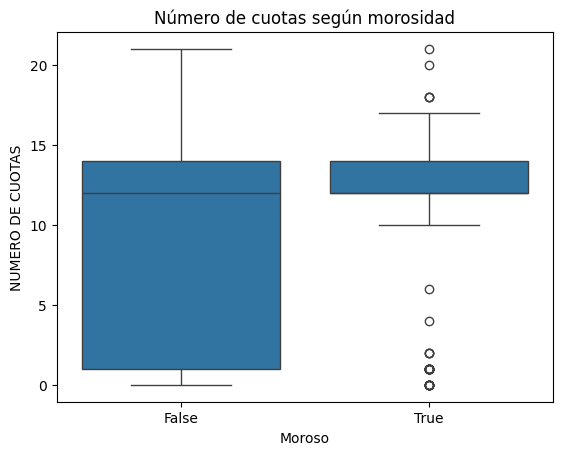

In [ ]:
sns.boxplot(x='Moroso', y='NUMERO DE CUOTAS', data=df_convo_deuda.reset_index())
plt.title('Número de cuotas según morosidad')
plt.show()



* Ver correlación numéricas con morosidad
* Ver correlación numéricas con % de deuda
* Ver LLM

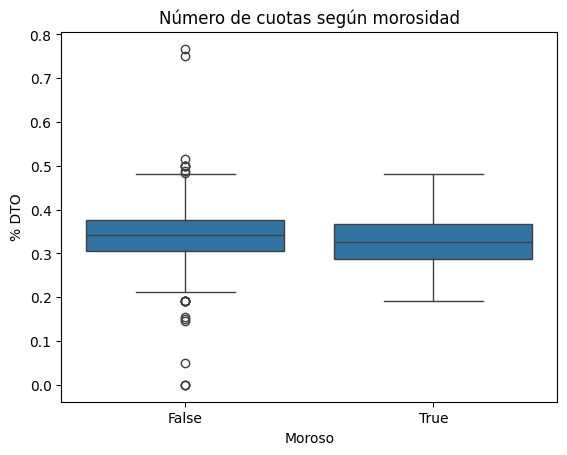

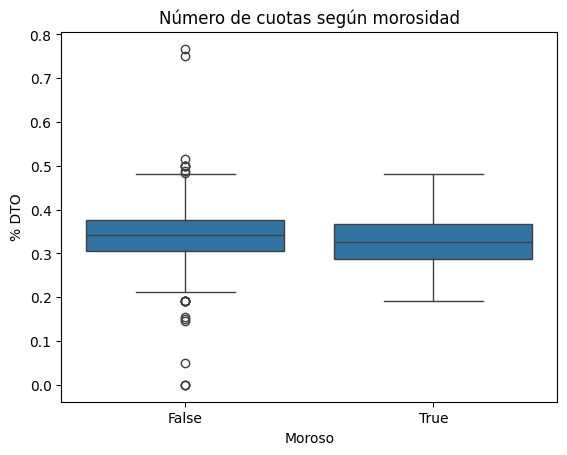

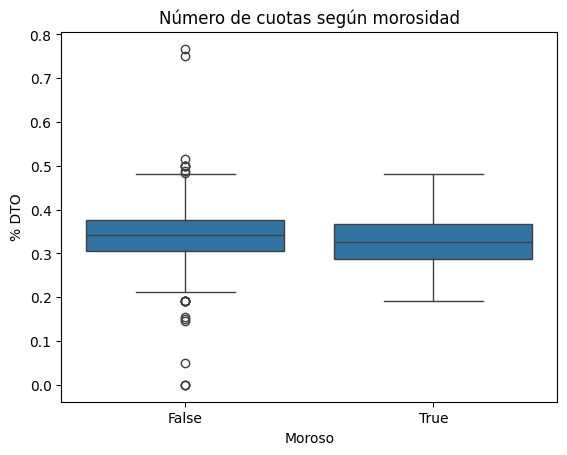

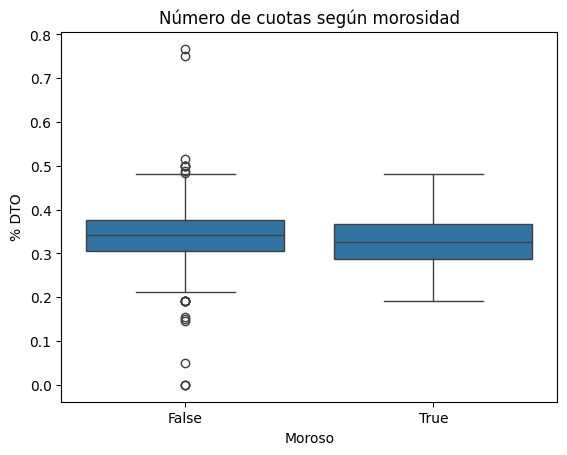

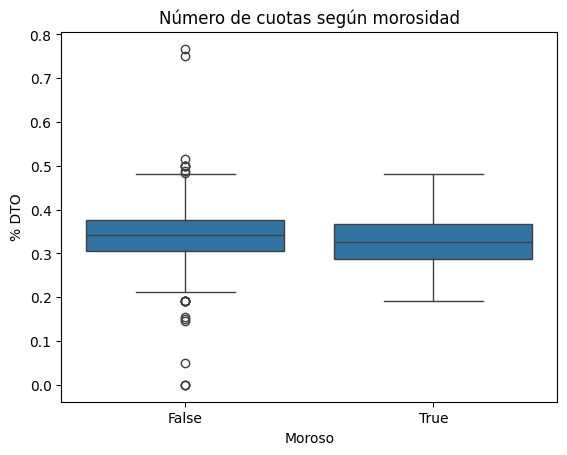

In [ ]:
for var in df_correlacion_num_sign['col']:  

    sns.boxplot(x='Moroso', y=col, data=df_convo_deuda.reset_index())
    plt.title('Número de cuotas según morosidad')
    plt.show()



*  correlacion como numericas entre %PI y % Impago
*  Colelación como categoricas entre %PI y % impago
*  correlacion como categoricas siendo las categoricas ==> ['0-13%', '14-15%', '16-20%', 'Resto']
* Dividir entre Master y MBA
